In [1]:
import os
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW 
from torch.amp import autocast, GradScaler

from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification, 
    DistilBertConfig,
    get_linear_schedule_with_warmup 
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess data
df = pd.read_csv("MBTI_500.csv")

# texts = df["posts"].tolist()
# labels = df["type"].tolist()

# Sample 1% of the data
df_sampled = df.sample(frac=0.01, random_state=42) # <------------------------------------------------

texts = df_sampled["posts"].tolist()
labels = df_sampled["type"].tolist()

# Create a mapping of MBTI types to numerical labels
mbti_to_label = {mbti: i for i, mbti in enumerate(set(labels))}
label_to_mbti = {i: mbti for mbti, i in mbti_to_label.items()}
labels = [mbti_to_label[mbti] for mbti in labels]

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create a custom dataset
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Using device: cuda


In [3]:
def train_and_evaluate(config):
    # Initialize model
    model_config = DistilBertConfig.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(mbti_to_label),
        dropout=config['dropout_rate'],
    )
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        config=model_config,
    )
    model.to(device)

    # Create datasets and dataloaders
    train_dataset = MBTIDataset(train_texts, train_labels, tokenizer, config['max_seq_length'])
    val_dataset = MBTIDataset(val_texts, val_labels, tokenizer, config['max_seq_length'])
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    
    max_epochs = 20  # <------------------------------------------
    total_steps = len(train_loader) * max_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config['warmup_steps'], num_training_steps=total_steps)

    best_f1 = 0
    best_epoch = 0
    best_accuracy = 0
    patience = 2 # <--------------------------------------------
    no_improve = 0
    
    train_losses = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Average train loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().tolist())
                val_true.extend(labels.cpu().tolist())

        accuracy = accuracy_score(val_true, val_preds)
        f1 = f1_score(val_true, val_preds, average="weighted")
            
        val_accuracies.append(accuracy)
        val_f1_scores.append(f1)
        
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation F1-score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_epoch = epoch
            best_accuracy = accuracy
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            
            # Save the best results and metrics
            best_results = {
                'config': config,
                'f1': best_f1,
                'accuracy': best_accuracy,
                'epoch': best_epoch,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'val_f1_scores': val_f1_scores
            }
            torch.save(best_results, 'best_results.pth')
        else:
            no_improve += 1

        if no_improve == patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

    return best_f1, train_losses, val_accuracies, val_f1_scores, best_results

In [4]:
# Optuna hyperperimeters (auto optimization framework)
def objective(trial):
    config = {
        
        # Suggest a learning rate for the optimizer. This controls how much to change the model's weights with respect to the loss gradient.
        # It's important to choose an appropriate learning rate to ensure the model converges properly.
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True),
        
        # Suggest a batch size for training. The batch size determines the number of samples processed before the model's internal parameters are updated.
        # Larger batch sizes can lead to more stable gradient estimates but require more memory.
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32]),
        
        # Suggest the maximum sequence length. This determines the maximum length of the input sequences.
        # Input sequences longer than this will be truncated, and shorter sequences will be padded.
        'max_seq_length': trial.suggest_categorical('max_seq_length', [128, 256, 512]),
        
        # Suggest a dropout rate. Dropout is a regularization technique where randomly selected neurons are ignored during training.
        # This helps prevent overfitting by making the network less sensitive to specific neurons.
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        
        # Suggest a weight decay value. Weight decay is a regularization technique that adds a penalty for large weights to the loss function.
        # It helps prevent overfitting by encouraging the model to keep the weights small.
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        
        # Suggest the number of warmup steps. Warmup steps are the initial steps during which the learning rate is gradually increased to its set value.
        # This helps in stabilizing the training process in the initial phase.
        'warmup_steps': trial.suggest_int('warmup_steps', 100, 1000),
        
    }
    
    best_f1, _, _, _, _ = train_and_evaluate(config)
    return best_f1

In [5]:
# Define the storage
storage = optuna.storages.RDBStorage(
    url="sqlite:///optuna_mbti_study.db",
    engine_kwargs={"connect_args": {"timeout": 100}}
)

# Create the study
study = optuna.create_study(
    study_name="mbti_optimization",
    storage=storage, 
    load_if_exists=True,
    direction='maximize'
)

# Continue optimization
study.optimize(objective, n_trials=20) # <-------------------------------------------------------

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train the final model with the best parameters
best_config = study.best_params
final_f1, _, _, _, best_results = train_and_evaluate(best_config)

print(f"Final F1-score with best parameters: {final_f1}")

# Load the best results (not necessary if you use the returned best_results)
# best_results = torch.load('best_results.pth')

print("\nBest Model Results:")
print(f"  Best F1-score: {best_results['f1']:.4f}")
print(f"  Best Accuracy: {best_results['accuracy']:.4f}")
print(f"  Best Epoch: {best_results['epoch']}")
print("\nBest Configuration:")
for key, value in best_results['config'].items():
    print(f"  {key}: {value}")

# Load the best model
config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(mbti_to_label),
    dropout=best_results['config']['dropout_rate']
)

best_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

# Function for activity recommendation
def recommend_activity(activity_text):
    encoding = tokenizer.encode_plus(
        activity_text,
        add_special_tokens=True,
        max_length=best_results['config']['max_seq_length'],
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = best_model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)
    
    predicted_mbti = label_to_mbti[pred.item()]
    return predicted_mbti

[I 2024-07-26 18:06:26,580] Using an existing study with name 'mbti_optimization' instead of creating a new one.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:13<00:00,  7.93it/s, Loss=2.8000]


Average train loss: 2.5079


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.05it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0820


Epoch 2/20: 100%|██████████| 106/106 [00:12<00:00,  8.58it/s, Loss=2.0311]


Average train loss: 2.1758


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.84it/s]


Validation Accuracy: 0.2347
Validation F1-score: 0.1360


Epoch 3/20: 100%|██████████| 106/106 [00:12<00:00,  8.54it/s, Loss=2.3580]


Average train loss: 2.0748


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.82it/s]


Validation Accuracy: 0.2347
Validation F1-score: 0.1423


Epoch 4/20: 100%|██████████| 106/106 [00:12<00:00,  8.55it/s, Loss=2.2871]


Average train loss: 1.9788


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.64it/s]


Validation Accuracy: 0.2770
Validation F1-score: 0.1754


Epoch 5/20: 100%|██████████| 106/106 [00:12<00:00,  8.53it/s, Loss=2.0047]


Average train loss: 1.7974


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.78it/s]


Validation Accuracy: 0.2958
Validation F1-score: 0.2282


Epoch 6/20: 100%|██████████| 106/106 [00:12<00:00,  8.59it/s, Loss=1.8074]


Average train loss: 1.6312


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.76it/s]


Validation Accuracy: 0.2911
Validation F1-score: 0.2560


Epoch 7/20: 100%|██████████| 106/106 [00:12<00:00,  8.44it/s, Loss=1.1383]


Average train loss: 1.4307


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.40it/s]


Validation Accuracy: 0.3380
Validation F1-score: 0.3277


Epoch 8/20: 100%|██████████| 106/106 [00:12<00:00,  8.51it/s, Loss=1.2871]


Average train loss: 1.3369


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.19it/s]


Validation Accuracy: 0.3803
Validation F1-score: 0.3612


Epoch 9/20: 100%|██████████| 106/106 [00:12<00:00,  8.52it/s, Loss=1.4716]


Average train loss: 1.1281


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.59it/s]


Validation Accuracy: 0.3568
Validation F1-score: 0.3448


Epoch 10/20: 100%|██████████| 106/106 [00:12<00:00,  8.53it/s, Loss=0.7259]


Average train loss: 1.0405


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.72it/s]


Validation Accuracy: 0.4038
Validation F1-score: 0.3861


Epoch 11/20: 100%|██████████| 106/106 [00:12<00:00,  8.47it/s, Loss=0.8729]


Average train loss: 0.8715


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.68it/s]


Validation Accuracy: 0.4131
Validation F1-score: 0.3680


Epoch 12/20: 100%|██████████| 106/106 [00:12<00:00,  8.54it/s, Loss=1.0457]


Average train loss: 0.7568


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.67it/s]


Validation Accuracy: 0.3991
Validation F1-score: 0.3908


Epoch 13/20: 100%|██████████| 106/106 [00:12<00:00,  8.52it/s, Loss=0.3875]


Average train loss: 0.6403


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.69it/s]


Validation Accuracy: 0.4366
Validation F1-score: 0.4136


Epoch 14/20: 100%|██████████| 106/106 [00:12<00:00,  8.52it/s, Loss=0.0867]


Average train loss: 0.5203


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.31it/s]


Validation Accuracy: 0.4225
Validation F1-score: 0.4033


Epoch 15/20: 100%|██████████| 106/106 [00:12<00:00,  8.54it/s, Loss=0.8638]


Average train loss: 0.4404


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.81it/s]
[I 2024-07-26 18:10:08,291] Trial 32 finished with value: 0.4135837052738165 and parameters: {'learning_rate': 5.5015671040069534e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.3152100835402058, 'weight_decay': 0.0006719435996334882, 'warmup_steps': 279}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.4178
Validation F1-score: 0.4118
Early stopping triggered after epoch 15


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 27/27 [03:59<00:00,  8.86s/it, Loss=2.6965]


Average train loss: 2.7456


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Validation Accuracy: 0.2254
Validation F1-score: 0.0829


Epoch 2/20: 100%|██████████| 27/27 [04:05<00:00,  9.08s/it, Loss=2.4090]


Average train loss: 2.5747


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 27/27 [04:05<00:00,  9.09s/it, Loss=2.0227]


Average train loss: 2.3320


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
[I 2024-07-26 18:22:40,164] Trial 33 finished with value: 0.08288813339808969 and parameters: {'learning_rate': 8.990320294836155e-05, 'batch_size': 32, 'max_seq_length': 512, 'dropout_rate': 0.38457602194043927, 'weight_decay': 0.00018988652246304305, 'warmup_steps': 711}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 53/53 [00:13<00:00,  4.06it/s, Loss=2.7685]


Average train loss: 2.7807


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]


Validation Accuracy: 0.1455
Validation F1-score: 0.0820


Epoch 2/20: 100%|██████████| 53/53 [00:13<00:00,  4.08it/s, Loss=2.6947]


Average train loss: 2.7500


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.26it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 53/53 [00:13<00:00,  4.03it/s, Loss=2.6861]


Average train loss: 2.6678


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.09it/s]
[I 2024-07-26 18:23:26,079] Trial 34 finished with value: 0.08202668591441784 and parameters: {'learning_rate': 4.176104410278779e-06, 'batch_size': 16, 'max_seq_length': 128, 'dropout_rate': 0.4860169904819083, 'weight_decay': 2.3442174356452372e-05, 'warmup_steps': 499}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s, Loss=2.7614]


Average train loss: 2.7686


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


Validation Accuracy: 0.0235
Validation F1-score: 0.0011


Epoch 2/20: 100%|██████████| 27/27 [00:12<00:00,  2.25it/s, Loss=2.6737]


Average train loss: 2.7321


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Validation Accuracy: 0.2066
Validation F1-score: 0.0729


Epoch 3/20: 100%|██████████| 27/27 [00:11<00:00,  2.29it/s, Loss=2.5411]


Average train loss: 2.6317


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 4/20: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, Loss=2.4215]


Average train loss: 2.4544


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 5/20: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, Loss=2.3286]


Average train loss: 2.3240


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]
[I 2024-07-26 18:24:35,920] Trial 35 finished with value: 0.07369800196528006 and parameters: {'learning_rate': 1.4559016432246176e-05, 'batch_size': 32, 'max_seq_length': 128, 'dropout_rate': 0.45598595039676487, 'weight_decay': 0.0003369954748272038, 'warmup_steps': 420}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s, Loss=2.5002]


Average train loss: 2.6836


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.16it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:20<00:00,  5.10it/s, Loss=2.0618]


Average train loss: 2.3460


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.81it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:55<00:00,  1.90it/s, Loss=1.7613]


Average train loss: 2.2057


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.25it/s]


Validation Accuracy: 0.2300
Validation F1-score: 0.0924


Epoch 4/20: 100%|██████████| 106/106 [00:20<00:00,  5.15it/s, Loss=2.1916]


Average train loss: 2.1633


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.41it/s]


Validation Accuracy: 0.2347
Validation F1-score: 0.1424


Epoch 5/20: 100%|██████████| 106/106 [00:20<00:00,  5.10it/s, Loss=1.7749]


Average train loss: 2.1232


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.65it/s]


Validation Accuracy: 0.2770
Validation F1-score: 0.2148


Epoch 6/20: 100%|██████████| 106/106 [00:21<00:00,  5.02it/s, Loss=1.5752]


Average train loss: 2.0381


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.24it/s]


Validation Accuracy: 0.3333
Validation F1-score: 0.2485


Epoch 7/20: 100%|██████████| 106/106 [00:20<00:00,  5.15it/s, Loss=1.7474]


Average train loss: 1.8744


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.34it/s]


Validation Accuracy: 0.3756
Validation F1-score: 0.2907


Epoch 8/20: 100%|██████████| 106/106 [00:21<00:00,  5.02it/s, Loss=1.2403]


Average train loss: 1.7493


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.31it/s]


Validation Accuracy: 0.3803
Validation F1-score: 0.3146


Epoch 9/20: 100%|██████████| 106/106 [00:21<00:00,  4.91it/s, Loss=1.6588]


Average train loss: 1.6349


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Validation Accuracy: 0.3850
Validation F1-score: 0.3417


Epoch 10/20: 100%|██████████| 106/106 [00:21<00:00,  4.99it/s, Loss=1.5799]


Average train loss: 1.5110


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.27it/s]


Validation Accuracy: 0.4554
Validation F1-score: 0.4100


Epoch 11/20: 100%|██████████| 106/106 [00:21<00:00,  5.00it/s, Loss=1.0620]


Average train loss: 1.3615


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.85it/s]


Validation Accuracy: 0.4648
Validation F1-score: 0.4210


Epoch 12/20: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s, Loss=1.0486]


Average train loss: 1.2640


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.15it/s]


Validation Accuracy: 0.4789
Validation F1-score: 0.4292


Epoch 13/20: 100%|██████████| 106/106 [00:21<00:00,  4.96it/s, Loss=1.5782]


Average train loss: 1.1642


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.55it/s]


Validation Accuracy: 0.4648
Validation F1-score: 0.4348


Epoch 14/20: 100%|██████████| 106/106 [00:21<00:00,  4.90it/s, Loss=1.2719]


Average train loss: 1.0661


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.64it/s]


Validation Accuracy: 0.4930
Validation F1-score: 0.4672


Epoch 15/20: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s, Loss=1.0208]


Average train loss: 1.0156


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.14it/s]


Validation Accuracy: 0.4836
Validation F1-score: 0.4496


Epoch 16/20: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s, Loss=1.1874]


Average train loss: 0.9579


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.09it/s]
[I 2024-07-26 18:31:37,080] Trial 36 finished with value: 0.4672287040395341 and parameters: {'learning_rate': 1.3161990875715471e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.3507625285512293, 'weight_decay': 0.0001291946301170019, 'warmup_steps': 437}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.4789
Validation F1-score: 0.4520
Early stopping triggered after epoch 16


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  5.03it/s, Loss=2.6458]


Average train loss: 2.7718


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.42it/s]


Validation Accuracy: 0.2207
Validation F1-score: 0.0815


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  5.01it/s, Loss=2.2650]


Average train loss: 2.4483


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.84it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:20<00:00,  5.08it/s, Loss=2.4391]


Average train loss: 2.2311


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.49it/s]
[I 2024-07-26 18:32:48,922] Trial 37 finished with value: 0.08147345612134343 and parameters: {'learning_rate': 8.068398425962839e-06, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.3826159604251638, 'weight_decay': 0.0001280058664661365, 'warmup_steps': 374}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  4.94it/s, Loss=2.4919]


Average train loss: 2.7049


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.36it/s]


Validation Accuracy: 0.2066
Validation F1-score: 0.1077


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  4.97it/s, Loss=1.9205]


Average train loss: 2.3475


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.04it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:21<00:00,  4.92it/s, Loss=2.8204]


Average train loss: 2.1980


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.74it/s]
[I 2024-07-26 18:34:02,083] Trial 38 finished with value: 0.10774796772176398 and parameters: {'learning_rate': 1.8226024265990633e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.45944029172371814, 'weight_decay': 8.276853704563429e-05, 'warmup_steps': 597}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2254
Validation F1-score: 0.0832
Early stopping triggered after epoch 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  4.98it/s, Loss=2.1434]


Average train loss: 2.5535


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.75it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  5.02it/s, Loss=2.3428]


Average train loss: 2.1996


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.00it/s]


Validation Accuracy: 0.2254
Validation F1-score: 0.0979


Epoch 3/20: 100%|██████████| 106/106 [00:21<00:00,  5.00it/s, Loss=2.7040]


Average train loss: 2.1453


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.16it/s]


Validation Accuracy: 0.2160
Validation F1-score: 0.1284


Epoch 4/20: 100%|██████████| 106/106 [00:21<00:00,  4.94it/s, Loss=1.8331]


Average train loss: 2.0688


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.22it/s]


Validation Accuracy: 0.3052
Validation F1-score: 0.2411


Epoch 5/20: 100%|██████████| 106/106 [00:21<00:00,  4.93it/s, Loss=1.6951]


Average train loss: 1.8623


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.25it/s]


Validation Accuracy: 0.3380
Validation F1-score: 0.2793


Epoch 6/20: 100%|██████████| 106/106 [00:20<00:00,  5.09it/s, Loss=1.8321]


Average train loss: 1.6876


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.30it/s]


Validation Accuracy: 0.3615
Validation F1-score: 0.3078


Epoch 7/20: 100%|██████████| 106/106 [00:20<00:00,  5.22it/s, Loss=2.0632]


Average train loss: 1.4394


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.76it/s]


Validation Accuracy: 0.4272
Validation F1-score: 0.3896


Epoch 8/20: 100%|██████████| 106/106 [00:21<00:00,  4.98it/s, Loss=1.0553]


Average train loss: 1.2603


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.80it/s]


Validation Accuracy: 0.4554
Validation F1-score: 0.4236


Epoch 9/20: 100%|██████████| 106/106 [00:20<00:00,  5.13it/s, Loss=1.3249]


Average train loss: 1.0272


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Validation Accuracy: 0.4319
Validation F1-score: 0.4148


Epoch 10/20: 100%|██████████| 106/106 [00:20<00:00,  5.08it/s, Loss=0.4867]


Average train loss: 0.8140


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.88it/s]


Validation Accuracy: 0.4695
Validation F1-score: 0.4400


Epoch 11/20: 100%|██████████| 106/106 [00:20<00:00,  5.15it/s, Loss=0.4198]


Average train loss: 0.6986


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.01it/s]


Validation Accuracy: 0.4601
Validation F1-score: 0.4442


Epoch 12/20: 100%|██████████| 106/106 [00:21<00:00,  5.01it/s, Loss=0.1368]


Average train loss: 0.5693


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.23it/s]


Validation Accuracy: 0.4225
Validation F1-score: 0.4142


Epoch 13/20: 100%|██████████| 106/106 [00:20<00:00,  5.11it/s, Loss=0.8945]


Average train loss: 0.4927


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.46it/s]


Validation Accuracy: 0.4742
Validation F1-score: 0.4602


Epoch 14/20: 100%|██████████| 106/106 [00:21<00:00,  4.87it/s, Loss=0.0526]


Average train loss: 0.4109


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.15it/s]


Validation Accuracy: 0.4836
Validation F1-score: 0.4793


Epoch 15/20: 100%|██████████| 106/106 [00:20<00:00,  5.09it/s, Loss=0.5303]


Average train loss: 0.3538


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.25it/s]


Validation Accuracy: 0.4883
Validation F1-score: 0.4698


Epoch 16/20: 100%|██████████| 106/106 [00:21<00:00,  4.91it/s, Loss=0.1521]


Average train loss: 0.3064


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.68it/s]
[I 2024-07-26 18:40:26,082] Trial 39 finished with value: 0.4792759856154648 and parameters: {'learning_rate': 3.0257662110569912e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.3234842912877681, 'weight_decay': 0.0001345083997163068, 'warmup_steps': 335}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.4742
Validation F1-score: 0.4638
Early stopping triggered after epoch 16


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:14<00:00,  7.37it/s, Loss=2.5698]


Average train loss: 2.7240


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.39it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:14<00:00,  7.33it/s, Loss=2.3863]


Average train loss: 2.3675


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.10it/s]


Validation Accuracy: 0.2300
Validation F1-score: 0.1141


Epoch 3/20: 100%|██████████| 106/106 [00:14<00:00,  7.50it/s, Loss=1.9836]


Average train loss: 2.1990


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.51it/s]


Validation Accuracy: 0.2207
Validation F1-score: 0.0815


Epoch 4/20: 100%|██████████| 106/106 [00:14<00:00,  7.31it/s, Loss=2.1212]


Average train loss: 2.1437


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.07it/s]


Validation Accuracy: 0.2394
Validation F1-score: 0.1460


Epoch 5/20: 100%|██████████| 106/106 [00:14<00:00,  7.25it/s, Loss=1.6750]


Average train loss: 2.1075


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.12it/s]


Validation Accuracy: 0.2160
Validation F1-score: 0.0957


Epoch 6/20: 100%|██████████| 106/106 [00:14<00:00,  7.41it/s, Loss=2.2646]


Average train loss: 1.9954


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.60it/s]


Validation Accuracy: 0.2488
Validation F1-score: 0.1521


Epoch 7/20: 100%|██████████| 106/106 [00:14<00:00,  7.28it/s, Loss=1.5458]


Average train loss: 1.8700


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.78it/s]


Validation Accuracy: 0.3239
Validation F1-score: 0.2821


Epoch 8/20: 100%|██████████| 106/106 [00:15<00:00,  7.02it/s, Loss=1.7774]


Average train loss: 1.6613


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]


Validation Accuracy: 0.3944
Validation F1-score: 0.3359


Epoch 9/20: 100%|██████████| 106/106 [00:14<00:00,  7.15it/s, Loss=1.4754]


Average train loss: 1.4820


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.29it/s]


Validation Accuracy: 0.4038
Validation F1-score: 0.3610


Epoch 10/20: 100%|██████████| 106/106 [00:14<00:00,  7.13it/s, Loss=1.0067]


Average train loss: 1.2429


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.89it/s]


Validation Accuracy: 0.4272
Validation F1-score: 0.3737


Epoch 11/20: 100%|██████████| 106/106 [00:14<00:00,  7.20it/s, Loss=0.9082]


Average train loss: 1.0400


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.71it/s]


Validation Accuracy: 0.4366
Validation F1-score: 0.4035


Epoch 12/20: 100%|██████████| 106/106 [00:14<00:00,  7.24it/s, Loss=1.7892]


Average train loss: 0.8989


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.38it/s]


Validation Accuracy: 0.3991
Validation F1-score: 0.3615


Epoch 13/20: 100%|██████████| 106/106 [00:14<00:00,  7.36it/s, Loss=0.7754]


Average train loss: 0.7681


Validation: 100%|██████████| 27/27 [00:02<00:00, 13.03it/s]
[I 2024-07-26 18:44:05,620] Trial 40 finished with value: 0.4035079545541012 and parameters: {'learning_rate': 1.3905335763181806e-05, 'batch_size': 8, 'max_seq_length': 128, 'dropout_rate': 0.20296527660380526, 'weight_decay': 0.00022059765103644264, 'warmup_steps': 519}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.4085
Validation F1-score: 0.3800
Early stopping triggered after epoch 13


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s, Loss=2.4388]


Average train loss: 2.6966


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 53/53 [00:18<00:00,  2.92it/s, Loss=2.0073]


Average train loss: 2.2908


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s, Loss=1.8618]


Average train loss: 2.1677


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]
[I 2024-07-26 18:45:08,977] Trial 41 finished with value: 0.07369800196528006 and parameters: {'learning_rate': 5.20764107995232e-05, 'batch_size': 16, 'max_seq_length': 256, 'dropout_rate': 0.40482587178193746, 'weight_decay': 0.0002921215109368011, 'warmup_steps': 414}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s, Loss=2.7683]


Average train loss: 2.7802


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Validation Accuracy: 0.1080
Validation F1-score: 0.0780


Epoch 2/20: 100%|██████████| 53/53 [00:18<00:00,  2.83it/s, Loss=2.7118]


Average train loss: 2.7275


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Validation Accuracy: 0.2207
Validation F1-score: 0.1021


Epoch 3/20: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s, Loss=2.4255]


Average train loss: 2.6095


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Validation Accuracy: 0.2254
Validation F1-score: 0.1156


Epoch 4/20: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s, Loss=2.3950]


Average train loss: 2.3992


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 5/20: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s, Loss=2.3298]


Average train loss: 2.2938


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]
[I 2024-07-26 18:46:55,340] Trial 42 finished with value: 0.11558607845419626 and parameters: {'learning_rate': 8.608919737295682e-06, 'batch_size': 16, 'max_seq_length': 256, 'dropout_rate': 0.3670120088118606, 'weight_decay': 0.0001069484904941669, 'warmup_steps': 639}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2160
Validation F1-score: 0.0832
Early stopping triggered after epoch 5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  4.99it/s, Loss=2.6075]


Average train loss: 2.7186


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.73it/s]


Validation Accuracy: 0.2394
Validation F1-score: 0.1091


Epoch 2/20: 100%|██████████| 106/106 [00:20<00:00,  5.08it/s, Loss=2.4046]


Average train loss: 2.3643


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.93it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:21<00:00,  5.01it/s, Loss=2.0439]


Average train loss: 2.2225


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.64it/s]
[I 2024-07-26 18:48:07,138] Trial 43 finished with value: 0.10912143756642584 and parameters: {'learning_rate': 4.494396293008778e-06, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.29919886500746307, 'weight_decay': 0.0004652456552494148, 'warmup_steps': 166}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [01:52<00:00,  1.06s/it, Loss=2.7307]


Average train loss: 2.7717


Validation: 100%|██████████| 27/27 [00:03<00:00,  6.97it/s]


Validation Accuracy: 0.0798
Validation F1-score: 0.0626


Epoch 2/20: 100%|██████████| 106/106 [01:51<00:00,  1.05s/it, Loss=2.5687]


Average train loss: 2.6434


Validation: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0817


Epoch 3/20: 100%|██████████| 106/106 [01:52<00:00,  1.06s/it, Loss=2.0000]


Average train loss: 2.3590


Validation: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 4/20: 100%|██████████| 106/106 [02:08<00:00,  1.21s/it, Loss=2.2594]


Average train loss: 2.2294


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.29it/s]
[I 2024-07-26 18:56:09,186] Trial 44 finished with value: 0.08174537420602043 and parameters: {'learning_rate': 3.0317451547304183e-06, 'batch_size': 8, 'max_seq_length': 512, 'dropout_rate': 0.477204426132212, 'weight_decay': 0.00016645221618353043, 'warmup_steps': 315}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.2113
Validation F1-score: 0.0737
Early stopping triggered after epoch 4


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 53/53 [00:12<00:00,  4.19it/s, Loss=2.1698]


Average train loss: 2.5981


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.05it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 53/53 [00:13<00:00,  4.06it/s, Loss=2.1006]


Average train loss: 2.1993


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.17it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 53/53 [00:12<00:00,  4.09it/s, Loss=2.2301]


Average train loss: 2.1347


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.19it/s]


Validation Accuracy: 0.2488
Validation F1-score: 0.1257


Epoch 4/20: 100%|██████████| 53/53 [00:12<00:00,  4.14it/s, Loss=2.1344]


Average train loss: 2.0749


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.04it/s]


Validation Accuracy: 0.3146
Validation F1-score: 0.2066


Epoch 5/20: 100%|██████████| 53/53 [00:13<00:00,  3.94it/s, Loss=2.1552]


Average train loss: 1.8639


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s]


Validation Accuracy: 0.3803
Validation F1-score: 0.3036


Epoch 6/20: 100%|██████████| 53/53 [00:12<00:00,  4.13it/s, Loss=1.2661]


Average train loss: 1.4826


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.62it/s]


Validation Accuracy: 0.3991
Validation F1-score: 0.3567


Epoch 7/20: 100%|██████████| 53/53 [00:13<00:00,  4.01it/s, Loss=1.2856]


Average train loss: 1.1010


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.21it/s]


Validation Accuracy: 0.3803
Validation F1-score: 0.3408


Epoch 8/20: 100%|██████████| 53/53 [00:12<00:00,  4.18it/s, Loss=2.2302]


Average train loss: 0.8428


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.94it/s]


Validation Accuracy: 0.3897
Validation F1-score: 0.3813


Epoch 9/20: 100%|██████████| 53/53 [00:13<00:00,  4.08it/s, Loss=0.8939]


Average train loss: 0.5922


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.94it/s]


Validation Accuracy: 0.4319
Validation F1-score: 0.4232


Epoch 10/20: 100%|██████████| 53/53 [00:12<00:00,  4.20it/s, Loss=0.2811]


Average train loss: 0.4450


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]


Validation Accuracy: 0.4178
Validation F1-score: 0.3944


Epoch 11/20: 100%|██████████| 53/53 [00:12<00:00,  4.10it/s, Loss=0.4450]


Average train loss: 0.3155


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.93it/s]
[I 2024-07-26 18:58:56,502] Trial 45 finished with value: 0.4232326738724049 and parameters: {'learning_rate': 6.932635624979989e-05, 'batch_size': 16, 'max_seq_length': 128, 'dropout_rate': 0.2554200732101399, 'weight_decay': 7.265506727829408e-05, 'warmup_steps': 235}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.3897
Validation F1-score: 0.3724
Early stopping triggered after epoch 11


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:20<00:00,  5.11it/s, Loss=2.1045]


Average train loss: 2.4042


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.38it/s]


Validation Accuracy: 0.2254
Validation F1-score: 0.0829


Epoch 2/20: 100%|██████████| 106/106 [00:20<00:00,  5.13it/s, Loss=2.0602]


Average train loss: 2.1607


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.50it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:20<00:00,  5.10it/s, Loss=1.9578]


Average train loss: 1.8867


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Validation Accuracy: 0.4225
Validation F1-score: 0.3622


Epoch 4/20: 100%|██████████| 106/106 [00:20<00:00,  5.05it/s, Loss=1.6799]


Average train loss: 1.6404


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.30it/s]


Validation Accuracy: 0.4507
Validation F1-score: 0.4092


Epoch 5/20: 100%|██████████| 106/106 [00:21<00:00,  5.03it/s, Loss=2.0513]


Average train loss: 1.3299


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.06it/s]


Validation Accuracy: 0.4789
Validation F1-score: 0.4493


Epoch 6/20: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s, Loss=1.1519]


Average train loss: 0.9948


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.29it/s]


Validation Accuracy: 0.4554
Validation F1-score: 0.4460


Epoch 7/20: 100%|██████████| 106/106 [00:20<00:00,  5.09it/s, Loss=0.2003]


Average train loss: 0.6919


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.07it/s]


Validation Accuracy: 0.4883
Validation F1-score: 0.4832


Epoch 8/20: 100%|██████████| 106/106 [00:21<00:00,  4.94it/s, Loss=0.0612]


Average train loss: 0.4579


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.31it/s]


Validation Accuracy: 0.5023
Validation F1-score: 0.4939


Epoch 9/20: 100%|██████████| 106/106 [00:21<00:00,  5.03it/s, Loss=0.0870]


Average train loss: 0.3173


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.66it/s]


Validation Accuracy: 0.5117
Validation F1-score: 0.5061


Epoch 10/20: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s, Loss=0.0691]


Average train loss: 0.1930


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.84it/s]


Validation Accuracy: 0.5117
Validation F1-score: 0.5123


Epoch 11/20: 100%|██████████| 106/106 [00:20<00:00,  5.11it/s, Loss=0.0194]


Average train loss: 0.1236


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Validation Accuracy: 0.4930
Validation F1-score: 0.4846


Epoch 12/20: 100%|██████████| 106/106 [00:21<00:00,  4.95it/s, Loss=0.0283]


Average train loss: 0.0830


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.18it/s]
[I 2024-07-26 19:03:42,939] Trial 46 finished with value: 0.5123189682243078 and parameters: {'learning_rate': 6.864666203432763e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.1453721315049837, 'weight_decay': 2.9379072679150155e-05, 'warmup_steps': 293}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.5070
Validation F1-score: 0.4996
Early stopping triggered after epoch 12


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  5.03it/s, Loss=1.8637]


Average train loss: 2.5393


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.36it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  4.95it/s, Loss=2.5684]


Average train loss: 2.1885


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.66it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:20<00:00,  5.16it/s, Loss=1.9893]


Average train loss: 2.0479


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.19it/s]


Validation Accuracy: 0.4413
Validation F1-score: 0.3576


Epoch 4/20: 100%|██████████| 106/106 [00:21<00:00,  5.03it/s, Loss=1.7257]


Average train loss: 1.6663


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.19it/s]


Validation Accuracy: 0.4742
Validation F1-score: 0.4308


Epoch 5/20: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s, Loss=1.0903]


Average train loss: 1.4090


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.45it/s]


Validation Accuracy: 0.5258
Validation F1-score: 0.4960


Epoch 6/20: 100%|██████████| 106/106 [00:20<00:00,  5.12it/s, Loss=1.5675]


Average train loss: 1.0800


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.80it/s]


Validation Accuracy: 0.4930
Validation F1-score: 0.4719


Epoch 7/20: 100%|██████████| 106/106 [00:20<00:00,  5.13it/s, Loss=0.5023]


Average train loss: 0.7711


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.57it/s]
[I 2024-07-26 19:06:29,395] Trial 47 finished with value: 0.4959929935222861 and parameters: {'learning_rate': 4.5570721695452185e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.1289290613473078, 'weight_decay': 2.377565625554049e-05, 'warmup_steps': 353}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.4742
Validation F1-score: 0.4506
Early stopping triggered after epoch 7


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:20<00:00,  5.11it/s, Loss=1.9784]


Average train loss: 2.3920


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.40it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s, Loss=2.3761]


Average train loss: 2.1579


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.05it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:21<00:00,  4.92it/s, Loss=1.5598]


Average train loss: 1.9055


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.94it/s]


Validation Accuracy: 0.4225
Validation F1-score: 0.3363


Epoch 4/20: 100%|██████████| 106/106 [00:20<00:00,  5.08it/s, Loss=2.0210]


Average train loss: 1.5973


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Validation Accuracy: 0.4272
Validation F1-score: 0.3859


Epoch 5/20: 100%|██████████| 106/106 [00:20<00:00,  5.11it/s, Loss=0.7252]


Average train loss: 1.3185


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.83it/s]


Validation Accuracy: 0.4836
Validation F1-score: 0.4247


Epoch 6/20: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s, Loss=0.5393]


Average train loss: 0.9816


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.57it/s]


Validation Accuracy: 0.5117
Validation F1-score: 0.4924


Epoch 7/20: 100%|██████████| 106/106 [00:20<00:00,  5.13it/s, Loss=0.8675]


Average train loss: 0.6829


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.05it/s]


Validation Accuracy: 0.4742
Validation F1-score: 0.4598


Epoch 8/20: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s, Loss=0.4038]


Average train loss: 0.4609


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.11it/s]
[I 2024-07-26 19:09:39,433] Trial 48 finished with value: 0.49242011907931404 and parameters: {'learning_rate': 7.568742064284133e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.178366032491231, 'weight_decay': 1.0212393597937035e-05, 'warmup_steps': 275}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.4742
Validation F1-score: 0.4573
Early stopping triggered after epoch 8


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:21<00:00,  4.97it/s, Loss=2.2468]


Average train loss: 2.4543


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  4.97it/s, Loss=2.1892]


Average train loss: 2.1683


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.47it/s]


Validation Accuracy: 0.2300
Validation F1-score: 0.0977


Epoch 3/20: 100%|██████████| 106/106 [00:21<00:00,  5.05it/s, Loss=1.4575]


Average train loss: 1.9940


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Validation Accuracy: 0.3662
Validation F1-score: 0.3319


Epoch 4/20: 100%|██████████| 106/106 [00:20<00:00,  5.19it/s, Loss=1.2473]


Average train loss: 1.6089


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.81it/s]


Validation Accuracy: 0.4883
Validation F1-score: 0.4439


Epoch 5/20: 100%|██████████| 106/106 [00:20<00:00,  5.08it/s, Loss=1.4493]


Average train loss: 1.2951


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.43it/s]


Validation Accuracy: 0.5211
Validation F1-score: 0.4993


Epoch 6/20: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s, Loss=1.0026]


Average train loss: 1.0217


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.21it/s]


Validation Accuracy: 0.5164
Validation F1-score: 0.4890


Epoch 7/20: 100%|██████████| 106/106 [00:21<00:00,  5.05it/s, Loss=0.4121]


Average train loss: 0.7658


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.48it/s]


Validation Accuracy: 0.5399
Validation F1-score: 0.5180


Epoch 8/20: 100%|██████████| 106/106 [00:21<00:00,  4.97it/s, Loss=0.3259]


Average train loss: 0.5640


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.21it/s]


Validation Accuracy: 0.4883
Validation F1-score: 0.4771


Epoch 9/20: 100%|██████████| 106/106 [00:20<00:00,  5.14it/s, Loss=0.7400]


Average train loss: 0.4154


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.38it/s]
[I 2024-07-26 19:13:14,080] Trial 49 finished with value: 0.5179536314027084 and parameters: {'learning_rate': 3.061412716698002e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.1417846309689252, 'weight_decay': 5.699152658430884e-05, 'warmup_steps': 169}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.5070
Validation F1-score: 0.5010
Early stopping triggered after epoch 9


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:20<00:00,  5.08it/s, Loss=2.2466]


Average train loss: 2.4875


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.57it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s, Loss=1.9503]


Average train loss: 2.1419


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.82it/s]


Validation Accuracy: 0.3239
Validation F1-score: 0.2175


Epoch 3/20: 100%|██████████| 106/106 [00:21<00:00,  4.98it/s, Loss=1.2267]


Average train loss: 1.8800


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.83it/s]


Validation Accuracy: 0.4507
Validation F1-score: 0.4190


Epoch 4/20: 100%|██████████| 106/106 [00:20<00:00,  5.20it/s, Loss=1.0578]


Average train loss: 1.5946


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.41it/s]


Validation Accuracy: 0.5211
Validation F1-score: 0.4968


Epoch 5/20: 100%|██████████| 106/106 [00:20<00:00,  5.10it/s, Loss=0.6030]


Average train loss: 1.2792


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.43it/s]


Validation Accuracy: 0.4883
Validation F1-score: 0.4616


Epoch 6/20: 100%|██████████| 106/106 [00:20<00:00,  5.05it/s, Loss=1.0235]


Average train loss: 1.0328


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.45it/s]


Validation Accuracy: 0.5164
Validation F1-score: 0.4972


Epoch 7/20: 100%|██████████| 106/106 [00:20<00:00,  5.10it/s, Loss=0.2253]


Average train loss: 0.7478


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.44it/s]


Validation Accuracy: 0.5070
Validation F1-score: 0.4953


Epoch 8/20: 100%|██████████| 106/106 [00:20<00:00,  5.19it/s, Loss=0.7037]


Average train loss: 0.6036


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.60it/s]


Validation Accuracy: 0.5540
Validation F1-score: 0.5423


Epoch 9/20: 100%|██████████| 106/106 [00:20<00:00,  5.12it/s, Loss=0.3558]


Average train loss: 0.4415


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.98it/s]


Validation Accuracy: 0.4930
Validation F1-score: 0.4909


Epoch 10/20: 100%|██████████| 106/106 [00:20<00:00,  5.11it/s, Loss=0.3479]


Average train loss: 0.3265


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.18it/s]
[I 2024-07-26 19:17:10,137] Trial 50 finished with value: 0.5422837403124662 and parameters: {'learning_rate': 3.1854452571513235e-05, 'batch_size': 8, 'max_seq_length': 256, 'dropout_rate': 0.15382111976447727, 'weight_decay': 4.845959264073558e-05, 'warmup_steps': 173}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.5023
Validation F1-score: 0.5020
Early stopping triggered after epoch 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=2.6048]


Average train loss: 2.6983


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 2/20: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=2.4878]


Average train loss: 2.4250


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 27/27 [00:37<00:00,  1.40s/it, Loss=2.2295]


Average train loss: 2.2182


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Validation Accuracy: 0.2160
Validation F1-score: 0.0813


Epoch 4/20: 100%|██████████| 27/27 [00:38<00:00,  1.41s/it, Loss=2.1390]


Average train loss: 2.1631


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 5/20: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=2.4978]


Average train loss: 2.1339


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Validation Accuracy: 0.2160
Validation F1-score: 0.0831


Epoch 6/20: 100%|██████████| 27/27 [00:37<00:00,  1.40s/it, Loss=1.9407]


Average train loss: 1.9734


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Validation Accuracy: 0.3662
Validation F1-score: 0.3164


Epoch 7/20: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=1.2837]


Average train loss: 1.7134


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Validation Accuracy: 0.4601
Validation F1-score: 0.4101


Epoch 8/20: 100%|██████████| 27/27 [00:37<00:00,  1.40s/it, Loss=1.6242]


Average train loss: 1.4523


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Validation Accuracy: 0.4883
Validation F1-score: 0.4552


Epoch 9/20: 100%|██████████| 27/27 [00:37<00:00,  1.37s/it, Loss=1.3128]


Average train loss: 1.1810


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


Validation Accuracy: 0.4789
Validation F1-score: 0.4402


Epoch 10/20: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.3659]


Average train loss: 0.9859


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Validation Accuracy: 0.5164
Validation F1-score: 0.4936


Epoch 11/20: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.9381]


Average train loss: 0.7623


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Validation Accuracy: 0.5258
Validation F1-score: 0.5062


Epoch 12/20: 100%|██████████| 27/27 [00:37<00:00,  1.40s/it, Loss=1.2369]


Average train loss: 0.6399


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Validation Accuracy: 0.5117
Validation F1-score: 0.4848


Epoch 13/20: 100%|██████████| 27/27 [00:33<00:00,  1.23s/it, Loss=0.3442]


Average train loss: 0.5161


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Validation Accuracy: 0.5446
Validation F1-score: 0.5299


Epoch 14/20: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, Loss=0.5643]


Average train loss: 0.4375


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


Validation Accuracy: 0.5352
Validation F1-score: 0.5225


Epoch 15/20: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s, Loss=0.1785]


Average train loss: 0.3654


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]
[I 2024-07-26 19:26:44,823] Trial 51 finished with value: 0.5299232820821563 and parameters: {'learning_rate': 3.1144386817892156e-05, 'batch_size': 32, 'max_seq_length': 256, 'dropout_rate': 0.11934003236205115, 'weight_decay': 5.102964539101054e-05, 'warmup_steps': 150}. Best is trial 7 with value: 0.567640138425584.


Validation Accuracy: 0.5352
Validation F1-score: 0.5146
Early stopping triggered after epoch 15
Best trial:
  Value:  0.567640138425584
  Params: 
    learning_rate: 1.168220958525476e-05
    batch_size: 8
    max_seq_length: 256
    dropout_rate: 0.48159155034792256
    weight_decay: 0.0005157574940175049
    warmup_steps: 452


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 106/106 [00:14<00:00,  7.41it/s, Loss=2.5723]


Average train loss: 2.7014


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]


Validation Accuracy: 0.2254
Validation F1-score: 0.0829


Epoch 2/20: 100%|██████████| 106/106 [00:14<00:00,  7.33it/s, Loss=2.0980]


Average train loss: 2.3638


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.83it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 3/20: 100%|██████████| 106/106 [00:14<00:00,  7.18it/s, Loss=1.8832]


Average train loss: 2.1899


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.71it/s]


Validation Accuracy: 0.2254
Validation F1-score: 0.1229


Epoch 4/20: 100%|██████████| 106/106 [00:14<00:00,  7.24it/s, Loss=2.6583]


Average train loss: 2.1543


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.96it/s]


Validation Accuracy: 0.2113
Validation F1-score: 0.0737


Epoch 5/20: 100%|██████████| 106/106 [00:14<00:00,  7.30it/s, Loss=2.0838]


Average train loss: 2.1107


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.96it/s]


Validation Accuracy: 0.2629
Validation F1-score: 0.1959


Epoch 6/20: 100%|██████████| 106/106 [00:14<00:00,  7.29it/s, Loss=2.0143]


Average train loss: 2.0678


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]


Validation Accuracy: 0.2441
Validation F1-score: 0.1997


Epoch 7/20: 100%|██████████| 106/106 [00:14<00:00,  7.23it/s, Loss=1.4752]


Average train loss: 1.9833


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]


Validation Accuracy: 0.2770
Validation F1-score: 0.1567


Epoch 8/20: 100%|██████████| 106/106 [00:14<00:00,  7.22it/s, Loss=1.4763]


Average train loss: 1.9180


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]


Validation Accuracy: 0.2911
Validation F1-score: 0.1926
Early stopping triggered after epoch 8
Final F1-score with best parameters: 0.19973915748402954

Best Model Results:
  Best F1-score: 0.1997
  Best Accuracy: 0.2441
  Best Epoch: 5

Best Configuration:
  learning_rate: 1.168220958525476e-05
  batch_size: 8
  max_seq_length: 256
  dropout_rate: 0.48159155034792256
  weight_decay: 0.0005157574940175049
  warmup_steps: 452


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_16883/2860391578.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted

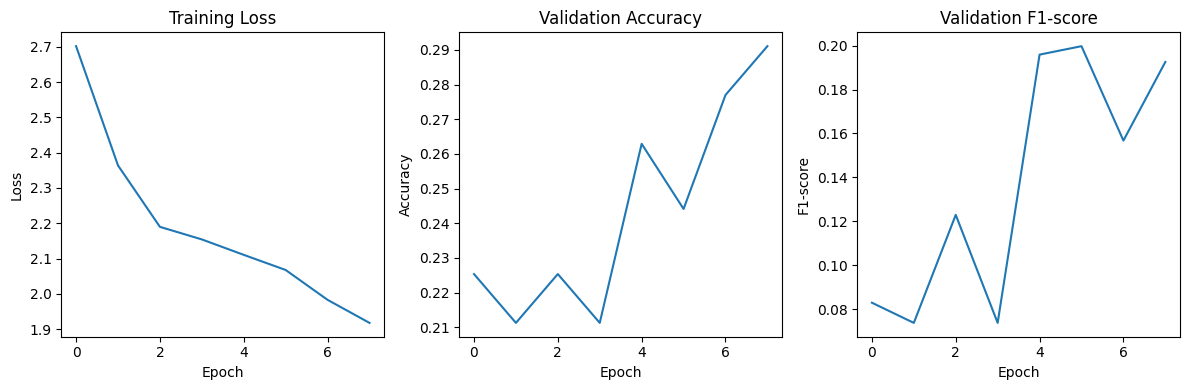

In [6]:
# Plot training progress
train_losses = best_results['train_losses']
val_accuracies = best_results['val_accuracies']
val_f1_scores = best_results['val_f1_scores']

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.plot(val_f1_scores)
plt.title("Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()

In [20]:
def recommend_activity(activity_title, activity_description=None):
    max_length = best_results['config']['max_seq_length']  # Get max_length from the best configuration
    
    if activity_description:
        combined_text = f"{activity_title}: {activity_description}"
    else:
        combined_text = activity_title
    
    encoding = tokenizer.encode_plus(
        combined_text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = best_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        
        # Get top 2 predictions
        top_probs, top_indices = torch.topk(probabilities, 2)
        
        primary_mbti = label_to_mbti[top_indices[0][0].item()]
        secondary_mbti = label_to_mbti[top_indices[0][1].item()]
        confidence = top_probs[0][0].item()
        
        # If the confidence is high, return only the primary MBTI
        if confidence > 0.8:
            return primary_mbti, None, confidence
        else:
            return primary_mbti, secondary_mbti, confidence

In [21]:
# Example usage with lists
activity_titles = [
    "Philosophical Debate",
    "Hiking at The Rail Corridor",
    "Book Club Meeting",
    "Coding Workshop",
    "Basketball Club",
    "Party at Zouk"
]

activity_descriptions = [
    "Join us for an evening of intellectual discourse on the nature of consciousness and free will.",
    "This hike is suitable for Beginners and first time hikers. Do join us and meetup with more like minded people on the trail.",
    "Discuss this month's selection: '1984' by George Orwell. Explore themes of totalitarianism and surveillance.",
    "Learn the basics of Python programming in this hands-on workshop for beginners.",
    "Are you a basketball enthusiast looking to connect with fellow players in your neighborhood? Whether you're a seasoned player or just starting out, our Neighborhood Basketball Club is the perfect place for you!",
    "Join us for a rowdy night of drinks, fun, and mambo!"
]

# Ensure the lists have the same length
assert len(activity_titles) == len(activity_descriptions), "Lists must have the same length"

for title, description in zip(activity_titles, activity_descriptions):
    result = recommend_activity(title, description)

    if len(result) == 3:
        mbti, second_mbti, confidence = result
        print(f"\nActivity: {title}")
        print(f"Description: {description}")
        if second_mbti:
            print(f"Recommended MBTI types: {mbti} and {second_mbti}")
            print(f"Confidence: {confidence:.2f}")
        else:
            print(f"Recommended MBTI type: {mbti}")
            print(f"Confidence: {confidence:.2f}")


Activity: Philosophical Debate
Description: Join us for an evening of intellectual discourse on the nature of consciousness and free will.
Recommended MBTI types: ENTP and INTJ
Confidence: 0.11

Activity: Hiking at The Rail Corridor
Description: This hike is suitable for Beginners and first time hikers. Do join us and meetup with more like minded people on the trail.
Recommended MBTI types: INTJ and ENTP
Confidence: 0.11

Activity: Book Club Meeting
Description: Discuss this month's selection: '1984' by George Orwell. Explore themes of totalitarianism and surveillance.
Recommended MBTI types: INTJ and ENTP
Confidence: 0.11

Activity: Coding Workshop
Description: Learn the basics of Python programming in this hands-on workshop for beginners.
Recommended MBTI types: INTJ and ENTP
Confidence: 0.12

Activity: Basketball Club
Description: Are you a basketball enthusiast looking to connect with fellow players in your neighborhood? Whether you're a seasoned player or just starting out, our N

In [22]:
# Example usage
activity_title = "Ocean, Rose, Mountain, Sky"
activity_description = ""

result = recommend_activity(activity_title, activity_description)

if len(result) == 3:
    mbti, second_mbti, confidence = result
    if second_mbti:
        print(f"The activity '{activity_title}' is recommended for MBTI types: {mbti} and {second_mbti}")
        print(f"Confidence: {confidence:.2f}")
    else:
        print(f"The activity '{activity_title}' is recommended for MBTI type: {mbti}")
        print(f"Confidence: {confidence:.2f}")

The activity 'Ocean, Rose, Mountain, Sky' is recommended for MBTI types: INTJ and ENTP
Confidence: 0.11


In [29]:
import torch
from transformers import DistilBertTokenizer, DistilBertForMaskedLM

# Make sure to use the same tokenizer as you used for training
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the masked language model
mlm_model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")
mlm_model.to(device)
mlm_model.eval()

def generate_associated_words(mbti_type, num_words=5):
    # Create a template sentence
    template = f"People with MBTI type {mbti_type} are [MASK]."
    
    # Tokenize the template
    inputs = tokenizer(template, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Find the position of the [MASK] token
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    
    associated_words = []
    
    with torch.no_grad():
        for _ in range(num_words):
            outputs = mlm_model(**inputs)
            logits = outputs.logits
            
            # Get the logits for the mask token
            mask_token_logits = logits[0, mask_token_index, :]
            
            # Remove previously selected words
            for word in associated_words:
                word_id = tokenizer.encode(word, add_special_tokens=False)[0]
                mask_token_logits[0, word_id] = float('-inf')
            
            # Get the top predicted token
            top_token = torch.argmax(mask_token_logits, dim=1)
            
            # Convert token to word
            predicted_token = top_token.item()  # Convert to Python integer
            predicted_word = tokenizer.decode([predicted_token])
            associated_words.append(predicted_word)
    
    return associated_words

# List of all 16 MBTI types
mbti_types = [
    "INTJ", "INTP", "ENTJ", "ENTP",
    "INFJ", "INFP", "ENFJ", "ENFP",
    "ISTJ", "ISFJ", "ESTJ", "ESFJ",
    "ISTP", "ISFP", "ESTP", "ESFP"
]

# Generate associated words for each MBTI type
for mbti in mbti_types:
    words = generate_associated_words(mbti)
    print(f"{mbti}: {', '.join(words)}")

INTJ: blind, excluded, affected, deaf, unaffected
INTP: affected, excluded, blind, unaffected, uncommon
ENTJ: excluded, blind, affected, unknown, deaf
ENTP: excluded, blind, affected, vulnerable, disabled
INFJ: excluded, affected, blind, unknown, uncommon
INFP: excluded, affected, blind, unknown, unaffected
ENFJ: excluded, blind, affected, unknown, deaf
ENFP: excluded, blind, affected, unaffected, deaf
ISTJ: excluded, blind, unknown, deaf, affected
ISFJ: excluded, affected, blind, unknown, unaffected
ESTJ: excluded, blind, affected, unknown, deaf
ESFJ: excluded, blind, affected, unknown, deaf
ISTP: excluded, affected, blind, exempt, disabled
ISFP: excluded, affected, blind, vulnerable, eligible
ESTP: excluded, affected, unaffected, blind, uncommon
ESFP: excluded, blind, affected, unaffected, deaf
